# Генеративно-состязательные сети на примере рост-вес

In [1]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# Height: в 1 дюйме 2,54 см
# Weight: в 1 фунте 0,453 кг

In [2]:
dataset = pd.read_csv("weight-height.csv") 
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  10000 non-null  float64
 1   Weight  10000 non-null  float64
dtypes: float64(2)
memory usage: 156.4 KB


In [3]:
X_1 = dataset.iloc[:, 0].values
X_2 = dataset.iloc[:, 1].values
X = np.column_stack((X_1, X_2)) 
print(X)

[[ 73.84701702 241.89356318]
 [ 68.78190405 162.31047252]
 [ 74.11010539 212.74085556]
 ...
 [ 63.86799221 128.47531878]
 [ 69.03424313 163.85246135]
 [ 61.94424588 113.64910268]]


In [4]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
new_X = min_max_scaler.fit_transform(X)
print(new_X)

[[0.79172838 0.863139  ]
 [0.58695829 0.4754764 ]
 [0.8023644  0.72113127]
 ...
 [0.38830089 0.31065968]
 [0.59715974 0.48298768]
 [0.31052854 0.23843869]]


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(new_X, test_size=0.2, random_state=0)
print(X_train)

[[0.20638286 0.26335674]
 [0.3902651  0.44852965]
 [0.76053157 0.71321052]
 ...
 [0.53380342 0.4762825 ]
 [0.31793625 0.3511279 ]
 [0.66033916 0.60280971]]


In [6]:
torch.manual_seed(100)

In [7]:
train_data_length = 8000
train_labels = torch.zeros(train_data_length)
train_data = torch.from_numpy(X_train).type(torch.FloatTensor)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

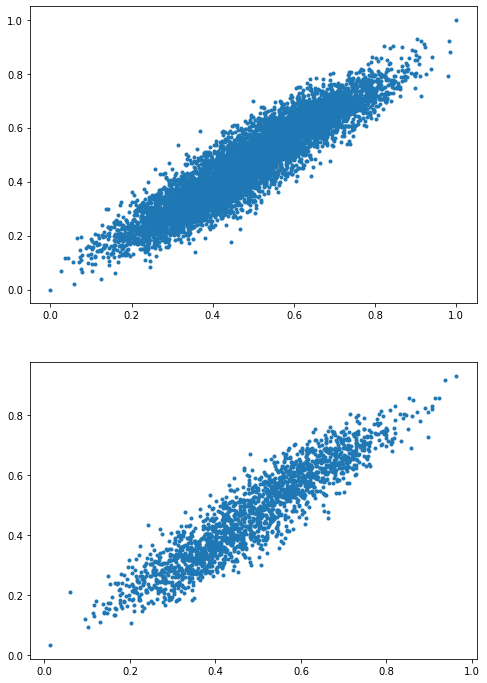

In [8]:
plt.figure(figsize=(8, 12))

plt.subplot(2, 1, 1)
plt.plot(X_train[:, 0], X_train[:, 1], ".")
plt.subplot(2, 1, 2)
plt.plot(X_test[:, 0], X_test[:, 1], ".")

In [9]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [11]:
discriminator = Discriminator()
generator = Generator()

In [12]:
lr = 0.001
num_epochs = 125
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 20 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.5624303817749023
Epoch: 0 Loss G.: 1.1637039184570312


 16%|█▌        | 20/125 [00:16<01:48,  1.04s/it]

Epoch: 20 Loss D.: 0.6929930448532104
Epoch: 20 Loss G.: 0.6929091811180115


 32%|███▏      | 40/125 [00:30<01:05,  1.31it/s]

Epoch: 40 Loss D.: 0.7042979001998901
Epoch: 40 Loss G.: 0.68752521276474


 48%|████▊     | 60/125 [00:47<00:46,  1.40it/s]

Epoch: 60 Loss D.: 0.6930990219116211
Epoch: 60 Loss G.: 0.6933252215385437


 64%|██████▍   | 80/125 [01:00<00:29,  1.54it/s]

Epoch: 80 Loss D.: 0.6910113096237183
Epoch: 80 Loss G.: 0.7165008783340454


 80%|████████  | 100/125 [01:12<00:15,  1.65it/s]

Epoch: 100 Loss D.: 0.7142146825790405
Epoch: 100 Loss G.: 0.7149751782417297


 96%|█████████▌| 120/125 [01:26<00:04,  1.03it/s]

Epoch: 120 Loss D.: 0.6961938142776489
Epoch: 120 Loss G.: 0.7144565582275391


100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


### Вывод графиков для сравнения показателей

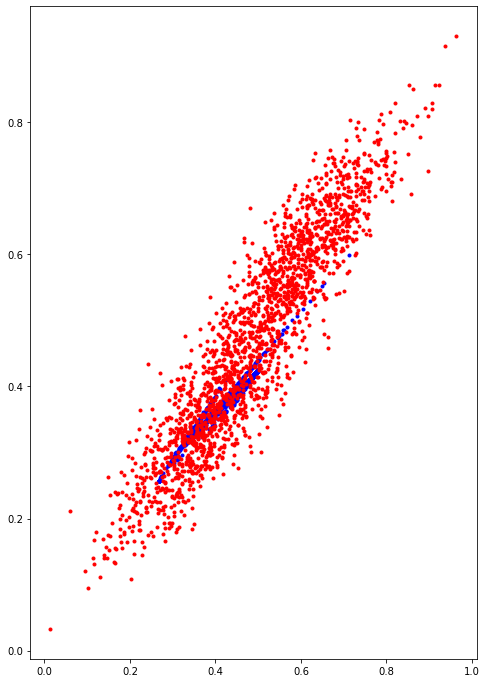

In [14]:
latent_space_samples = torch.randn(2000, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

plt.figure(figsize=(8, 12))
plt.plot(generated_samples[:, 0], generated_samples[:, 1], "b.",
         X_test[:, 0], X_test[:, 1], "r.")